In [ ]:
import torch
import numpy as np
import math
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import time
import sys
import os 
from scipy.sparse import linalg
from pathlib import Path
if torch.cuda.is_available():  
    device = "cuda" 
else:  
    device = "cpu" 

torch.set_default_dtype(torch.float64)
pi = torch.tensor(np.pi,dtype=torch.float64)
ZERO = torch.tensor([0.]).to(device)


class model(nn.Module):
    """ ReLU k shallow neural network
    Parameters: 
    input size: input dimension
    hidden_size1 : number of hidden layers 
    num_classes: output classes 
    k: degree of relu functions
    """
    def __init__(self, input_size, hidden_size1, num_classes,k = 1):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias = False)
        self.k = k 
    def forward(self, x):
        u1 = self.fc2(F.relu(self.fc1(x))**self.k)
        return u1
    def evaluate_derivative(self, x, i):
        if self.k == 1:
            ## ZERO = torch.tensor([0.]).to(device)
            u1 = self.fc2(torch.heaviside(self.fc1(x),ZERO) * self.fc1.weight.t()[i-1:i,:] )
        else:
            u1 = self.fc2(self.k*F.relu(self.fc1(x))**(self.k-1) *self.fc1.weight.t()[i-1:i,:] )  
        return u1

## define the nonlinearity 
def nonlinear(v):
    return torch.sinh(v)

def nonlinear_prime(v):
    return torch.cosh(v)

In [ ]:

def PiecewiseGQ1D_weights_points(x_l,x_r,Nx, order):
    """ Output the coeffients and weights for piecewise Gauss Quadrature 
    Parameters
    ----------
    x_l : float 
    left endpoint of an interval 
    x_r: float
    right endpoint of an interval 
    Nx: int 
    number of subintervals for integration
    order: int
    order of Gauss Quadrature 
    Returns
    -------
    vectorized quadrature weights and integration points
    """
    x,w = np.polynomial.legendre.leggauss(order)
    gx = torch.tensor(x).to(device)
    gx = gx.view(1,-1) # row vector 
    gw = torch.tensor(w).to(device)    
    gw = gw.view(-1,1) # Column vector 
    nodes = torch.linspace(x_l,x_r,Nx+1).view(-1,1).to(device) 
    coef1 = ((nodes[1:,:] - nodes[:-1,:])/2) # n by 1  
    coef2 = ((nodes[1:,:] + nodes[:-1,:])/2) # n by 1  
    coef2_expand = coef2.expand(-1,gx.size(1)) # Expand to n by p shape, -1: keep the first dimension n , expand the 2nd dim (columns)
    integration_points = coef1@gx + coef2_expand
    integration_points = integration_points.flatten().view(-1,1) # Make it a column vector
    gw_expand = torch.tile(gw,(Nx,1)) # rows: n copies of current tensor, columns: 1 copy, no change
    # Modify coef1 to be compatible with func_values
    coef1_expand = coef1.expand(coef1.size(0),gx.size(1))    
    coef1_expand = coef1_expand.flatten().view(-1,1)
    return coef1_expand.to(device) * gw_expand.to(device), integration_points.to(device)

def plot_solution_modified(r1,r2,model,x_test,u_true,name=None): 
    # Plot function: test results 
    u_model_cpu = model(x_test).cpu().detach()
    
    w = model.fc1.weight.data.squeeze()
    b = model.fc1.bias.data.squeeze()
    x_model_pt = (-b/w).view(-1,1)
    x_model_pt = x_model_pt[x_model_pt>=r1].reshape(-1,1)
    u_model_pt = model(x_model_pt).cpu().detach()
    plt.figure(dpi = 100)
    plt.plot(x_test.cpu(),u_model_cpu,'-.',label = "nn function")
    plt.plot(x_test.cpu(),u_true.cpu(),label = "true")
    plt.plot(x_model_pt.cpu(),u_model_pt.cpu(),'.r')
    if name!=None: 
        plt.title(name)
    plt.legend()
    plt.show()
    
def show_convergence_order2(err_l2,err_h10,exponent,dict_size, filename,write2file = False):
    
    if write2file:
        file_mode = "a" if os.path.exists(filename) else "w"
        f_write = open(filename, file_mode)
    
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    # f_write.write('M:{}, relu {} \n'.format(M,k))
    if write2file:
        f_write.write('dictionary size: {}\n'.format(dict_size))
        f_write.write("neuron num \t\t error \t\t order \t\t h10 error \\ order \n")
    print("neuron num \t\t error \t\t order")
    for i, item in enumerate(err_list):
        if i == 0: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t")
            
            # print("*")
            print("{} \t\t {:.6f} \t\t * \t\t {:.6f} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t * \t\t {} \t\t * \n".format(neuron_nums[i],item, err_list2[i] ))
        else: 
            # print(neuron_nums[i], end = "\t\t")
            # print(item, end = "\t\t") 
            # print(np.log(err_list[i-1]/err_list[i])/np.log(2))
            print("{} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \t\t {:.6f} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )
            if write2file: 
                f_write.write("{} \t\t {} \t\t {} \t\t {} \t\t {} \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ))
    if write2file:     
        f_write.write("\n")
        f_write.close()

def show_convergence_order_latex2(err_l2,err_h10,exponent,k=1,d=1): 
    neuron_nums = [2**j for j in range(2,exponent+1)]
    err_list = [err_l2[i] for i in neuron_nums ]
    err_list2 = [err_h10[i] for i in neuron_nums ] 
    l2_order = -1/2-(2*k + 1)/(2*d)
    h1_order =  -1/2-(2*(k-1)+ 1)/(2*d)
    print("neuron num  & \t $\|u-u_n \|_{{L^2}}$ & \t order $O(n^{{{:.2f}}})$  & \t $ | u -u_n |_{{H^1}}$ & \t order $O(n^{{{:.2f}}})$  \\\ \hline \hline ".format(l2_order,h1_order))
    for i, item in enumerate(err_list):
        if i == 0: 
            print("{} \t\t & {:.6f} &\t\t * & \t\t {:.6f} & \t\t *  \\\ \hline  \n".format(neuron_nums[i],item, err_list2[i] ) )   
        else: 
            print("{} \t\t &  {:.3e} &  \t\t {:.2f} &  \t\t {:.3e} &  \t\t {:.2f} \\\ \hline  \n".format(neuron_nums[i],item,np.log(err_list[i-1]/err_list[i])/np.log(2),err_list2[i] , np.log(err_list2[i-1]/err_list2[i])/np.log(2) ) )


In [22]:

def minimize_linear_layer_explicit_assemble(model,target,weights, integration_points,solver="direct"):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    jac = weighted_basis_value_col.t() @ basis_value_col 
     
    rhs = weighted_basis_value_col.t() @ (target(integration_points)) 
    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    return sol 

In [23]:
# relu dictionary
def relu_dict(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    relu_dict_parameters = torch.zeros((2*N,2)).to(device)
    relu_dict_parameters[:N,0] = torch.ones(N)[:]
    relu_dict_parameters[:N,1] = torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)  
    relu_dict_parameters[N:2*N,0] = -torch.ones(N)[:]
    relu_dict_parameters[N:2*N,1] = -torch.linspace(x_l,x_r,N+1)[1:] + 1/(2*N) # relu(-x - -bi) 
    
    return relu_dict_parameters

# relu dictionary
def relu_dict_MC(x_l,x_r,N):
    """generate relu dictionary parameters 
    
    Parameters
    ----------
    x_l: float 
    x_r: float
    N: int 
        number of degree of freedoms
        
    Returns
    torch tensor
        containing relu dictionary parameters, corresponds to nodal points
        
    """
    # w = 1 
    random_value = torch.randint(0, 2, (N,)) * 2 - 1 # +1 or -1  
    relu_dict_parameters = torch.zeros((N,2)).to(device)
    relu_dict_parameters[:N,0] = random_value[:]
    relu_dict_parameters[:N,1] = (torch.rand(N)*(x_r-x_l) + x_l)*random_value # relu(x-bi) 
    # torch.linspace(x_l,x_r,N+1)[:-1] # relu(x-bi)
    
    return relu_dict_parameters

In [31]:
def H1_projection_init(model,sol, weights,integration_points,activation = 'relu', solver = 'direct'):
    """
    the first n-1 neurons gives the target function for the H1 projection 
    """
    #assemble the projection matrix using the basis functions 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    # stiffness matrix 
    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
    jac = jac1 + jac2

    rhs = jac[:,:-1] @ sol.t() 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)

    model.fc2.weight.data[0,:] = sol[0,:] 
    return model 

def L2_projection_init(model,sol, weights,integration_points,activation = 'relu', solver = 'direct'):
    """
    the first n-1 neurons gives the target function for the H1 projection 
    """
    #assemble the projection matrix using the basis functions 
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    jac = jac2

    rhs = jac[:,:-1] @ sol.t() 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)

    model.fc2.weight.data[0,:] = sol[0,:] 
    return model 


def minimize_linear_layer_neumann(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N, activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    
    coef_func = 1 # 3 * model(integration_points).detach()**2 #changing after each newton iteration 
    jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

    # stiffness matrix 
    if activation == 'relu':
        basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
        if model.k == 1:  
            basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
        else: 
            basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
    weighted_basis_value_dx_col = basis_value_dx_col * weights
    jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
    jac = jac1 + jac2


    rhs1 = weighted_basis_value_col.t() @ (target(integration_points) )
    print("rhs1 ",rhs1.size()) 
    # Neumman boundary condition
    basis_value_col_bd = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
    weighted_basis_value_col_bd = basis_value_col_bd *weights_bd 
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device) 
    rhs2 =  weighted_basis_value_col_bd.t() @ dudn
    print("rhs2 ",rhs2.size()) 
    rhs = rhs1 + rhs2 

    print("assembling the matrix time taken: ", time.time()-start_time) 
    start_time = time.time()    
    if solver == "cg": 
        sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
        sol = torch.tensor(sol).view(1,-1)
    elif solver == "direct": 
#         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
        sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
    elif solver == "ls":
        sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
        # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
    print("solving Ax = b time taken: ", time.time()-start_time)
    ## update the solution 
    return sol 

def minimize_linear_layer_newton_method_pbe(model,target,weights, integration_points,weights_bd, integration_points_bd, g_N,activation = 'relu', solver = 'direct'):
    """
    calls the following functions (dependency): 
    1. GQ_piecewise_2D
    input: the nn model containing parameter 
    1. define the loss function  
    2. take derivative to extract the linear system A
    3. call the cg solver in scipy to solve the linear system 
    output: sol. solution of Ax = b
    """
    start_time = time.time() 
    w = model.fc1.weight.data 
    b = model.fc1.bias.data 
    basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
    weighted_basis_value_col = basis_value_col * weights 
    
    newton_iters = 20

    # neumann boundary condition 
    if g_N != None:
        basis_value_col_bd = F.relu(integration_points_bd @ w.t()+ b)**(model.k) 
        weighted_basis_value_col_bd = basis_value_col_bd *weights_bd 
        dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device) 
        rhs3 =  weighted_basis_value_col_bd.t() @ dudn
    else:
        rhs3 = 0 
    
    for i in range(newton_iters): 
        print("newton iteration: ", i+1) 
        # coef_func = 3 * model(integration_points).detach()**2 #changing after each newton iteration 
        coef_func = nonlinear_prime(model(integration_points).detach()) #changing after each newton iteration
        jac2 = weighted_basis_value_col.t() @ (coef_func*basis_value_col) 

        # stiffness matrix 
        if activation == 'relu':
            basis_value_col = F.relu(integration_points @ w.t()+ b)**(model.k) 
            if model.k == 1:  
                basis_value_dx_col = torch.heaviside(integration_points @ w.t()+ b, ZERO) * w.t()[0:1,:] 
            else: 
                basis_value_dx_col = model.k * F.relu(integration_points @ w.t()+ b)**(model.k-1) * w.t()[0:1,:]
        weighted_basis_value_dx_col = basis_value_dx_col * weights
        jac1 =  weighted_basis_value_dx_col.t() @ basis_value_dx_col 
        jac = jac1 + jac2

        rhs1 = weighted_basis_value_col.t() @ (target(integration_points) - nonlinear(model(integration_points).detach()) )


        if model!= None:
            dmy_model_dx1 = model.evaluate_derivative(integration_points,1).detach()
            dmy_model_dx1_boundary = model.evaluate_derivative(integration_points_bd,1).detach() * (torch.tensor([-1.,1.]).view(-1,1).to(device))
            rhs2 =  - weighted_basis_value_dx_col.t() @ dmy_model_dx1 # gradient term 
            rhs = rhs1 + rhs2 +rhs3   
        else: 
            rhs = rhs1 +rhs3 

        # print("assembling the matrix time taken: ", time.time()-start_time) 
        start_time = time.time()    
        if solver == "cg": 
            sol, exit_code = linalg.cg(np.array(jac.detach().cpu()),np.array(rhs.detach().cpu()),tol=1e-12)
            sol = torch.tensor(sol).view(1,-1)
        elif solver == "direct": 
    #         sol = np.linalg.inv( np.array(jac.detach().cpu()) )@np.array(rhs.detach().cpu())
            sol = (torch.linalg.solve( jac.detach(), rhs.detach())).view(1,-1)
        elif solver == "ls":
            sol = (torch.linalg.lstsq(jac.detach().cpu(),rhs.detach().cpu(),driver='gelsd').solution).view(1,-1)
            # sol = (torch.linalg.lstsq(jac.detach(),rhs.detach()).solution).view(1,-1) # gpu/cpu, driver = 'gels', cannot solve singular
        # print("solving Ax = b time taken: ", time.time()-start_time)
        ## update the solution 
        print(sol.size())
        # print(sol)
        model.fc2.weight.data[0,:] += sol[0,:]

        # print("newton iteration: ", i) 
        sol_update_l2_norm = torch.norm(sol)
        nn_linear_layer_l2_norm = torch.norm(model.fc2.weight.data[0,:])
        residual_l2_norm = torch.norm(rhs) 
        # print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        tol = 1e-10
        print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
        if sol_update_l2_norm < tol*nn_linear_layer_l2_norm or sol_update_l2_norm < tol or residual_l2_norm < tol*1e-3: 
            print("converged at iteration: ", i+1 )
            print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))
            return model.fc2.weight.data[:,:] 
    print("Newton solver NOT converged at iteration!!! ")
    print("sol_update_l2_norm:{} \t residual l2 norm: {} ".format(sol_update_l2_norm, residual_l2_norm))

    return model.fc2.weight.data[:,:] 


## Convergence order test 

In [32]:
def select_greedy_neuron_ind_nonlinearPoisson(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd,k): 

    residual_values = - target(integration_points)
    if my_model!= None:
        residual_values += nonlinear(my_model(integration_points).detach()) # pbe  

    weight_func_values = residual_values*weights

    basis_values = (F.relu(relu_dict_parameters[:,0] *integration_points - relu_dict_parameters[:,1])**k).T # uses broadcasting
    
    output1 = torch.matmul(basis_values,weight_func_values) # 

    if k == 1:  
        dbasis_values_dx1 =  torch.heaviside(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1], ZERO) * relu_dict_parameters.t()[0:1,:]   
    else:  
        dbasis_values_dx1 = k * F.relu(integration_points @ (relu_dict_parameters[:,0:1].T) - relu_dict_parameters[:,1])**(k-1) * relu_dict_parameters.t()[0:1,:] 

    weight_dbasis_values_dx1 =  dbasis_values_dx1 * weights
    
    # Neumann boundary condition 
    basis_values_bd_col = (F.relu(relu_dict_parameters[:,0] *integration_points_bd - relu_dict_parameters[:,1])**k) 
    print(basis_values_bd_col.size())

    weighted_basis_value_col_bd = basis_values_bd_col * weights_bd
    dudn = g_N(integration_points_bd)* (torch.tensor([-1,1]).view(-1,1)).to(device)
    output3 =  weighted_basis_value_col_bd.t() @ dudn


    if my_model!= None:
        dmy_model_dx1 = my_model.evaluate_derivative(integration_points,1).detach()
        output2 = torch.matmul(weight_dbasis_values_dx1.t(), dmy_model_dx1) 
        output = torch.abs(output1 + output2 - output3)
        print("two outputs")
    else:
        output = torch.abs(output1 - output3)
        print("one output")
    neuron_index = torch.argmax(output.flatten())
    
    return neuron_index 

def CGAPBEReLU1D(my_model,target,u_exact,du_exact,g_N, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [-pi,pi]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r=1, Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(M = 2,dim = 1) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    if my_model!= None:
        err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5
    else: 
        err_h10[0] = torch.sum( du_exact(integration_points)**2*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        print('epoch: ',i+1)

        start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind_nonlinearPoisson(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd, k) 
        
        print("argmax time: ", time.time() - start_argmax) 
        print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1]) # different sign convention 
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
        if num_neuron <=2: 
            my_model.fc2.weight.data[0,:] = 0.0001
        else: 
            ## Initial guess: option 1 
            my_model.fc2.weight.data[0,:num_neuron -1 ] = sol[:] # projection of previous solution
            my_model.fc2.weight.data[0,num_neuron-1:num_neuron ] = 0.000001
            
            ## Option 2:  H1 projection onto previous solution 
            # my_model = H1_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 
            ## Option 3:  L2 projection onto previous solution 
#             my_model = L2_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 

        sol = minimize_linear_layer_newton_method_pbe(my_model,target,weights, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = u_exact(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
        err_h10[i+1] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5 
    print("time taken: ",time.time() - start_time)
    return err, err_h10, my_model


## randomized CGA 

def CGARandPBEReLU1D(my_model,target,u_exact,du_exact,g_N, N,num_epochs,plot_freq = 10,Nx = 1024,order =5, k = 1, solver = 'direct'): 
    """ Orthogonal greedy algorithm using 1D ReLU dictionary over [0,1]
    Parameters
    ----------
    my_model: 
        nn model 
    target: 
        target function
    num_epochs: int 
        number of training epochs 
    integration_intervals: int 
        number of subintervals for piecewise numerical quadrature 

    Returns
    -------
    err: tensor 
        rank 1 torch tensor to record the L2 error history  
    model: 
        trained nn model 
    """

    weights, integration_points = PiecewiseGQ1D_weights_points(x_l= 0,x_r=1, Nx = Nx,order =order)
    weights_bd, integration_points_bd = Neumann_boundary_quadrature_points(M = 2,dim = 1) 

    err = torch.zeros(num_epochs+1)
    err_h10 = torch.zeros(num_epochs+1) 
    if my_model == None: 
        func_values = u_exact(integration_points)
        num_neuron = 0
        list_a = []
        list_b = []
        list_w = []
    else: 
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        bias = my_model.fc1.bias.detach().data
        weights = my_model.fc1.weight.detach().data
        num_neuron = int(bias.size(0))
        list_a = list(my_model.fc2.weight.detach().data)
        list_b = list(bias)
        list_w = list(weights)
        
    func_values_sqrd = func_values*func_values
    err[0]= torch.sum(func_values_sqrd*weights)**0.5
    if my_model!= None:
        err_h10[0] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5
    else: 
        err_h10[0] = torch.sum( du_exact(integration_points)**2*weights)**0.5
    start_time = time.time()
    
    solver = "direct"
    print("using linear solver: ",solver)
    # relu_dict_parameters = relu_dict(0,1,N).to(device) 
    for i in range(num_epochs): 
        relu_dict_parameters = relu_dict_MC(0,1,N).to(device)  
        print('epoch: ',i+1)

        start_argmax = time.time() 
        neuron_index = select_greedy_neuron_ind_nonlinearPoisson(relu_dict_parameters,my_model,target,weights, integration_points,g_N,weights_bd, integration_points_bd, k) 
        
        print("argmax time: ", time.time() - start_argmax) 
        print("selected neuron index: ",neuron_index,relu_dict_parameters[neuron_index,0],-relu_dict_parameters[neuron_index,1] ) 
        list_w.append(relu_dict_parameters[neuron_index,0])
        list_b.append(-relu_dict_parameters[neuron_index,1]) # different sign convention 
        num_neuron += 1
        my_model = model(1,num_neuron,1,k).to(device)
        my_model.fc1.weight.data[:,0] = torch.tensor(list_w)[:]
        my_model.fc1.bias.data[:] = torch.tensor(list_b)[:]
        if num_neuron <=2: 
            my_model.fc2.weight.data[0,:] = 0.0001
        else: 
            ## Initial guess: option 1 
            my_model.fc2.weight.data[0,:num_neuron -1 ] = sol[:] # projection of previous solution
            my_model.fc2.weight.data[0,num_neuron-1:num_neuron ] = 0.000001
            
            ## Option 2:  H1 projection onto previous solution 
            # my_model = H1_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 
            ## Option 3:  L2 projection onto previous solution 
#             my_model = L2_projection_init(my_model,sol,weights,integration_points,activation = 'relu', solver = solver) 

        sol = minimize_linear_layer_newton_method_pbe(my_model,target,weights, integration_points,weights_bd, integration_points_bd,g_N,activation ='relu', solver = solver)
        
        sol = sol.flatten() 
        my_model.fc2.weight.data[0,:] = sol[:]

        if (i+1)%plot_freq == 0: 
            x_test = torch.linspace(0,1,200).view(-1,1).to(device)
            u_true = u_exact(x_test)
            plot_solution_modified(0,1,my_model,x_test,u_true)
        func_values = u_exact(integration_points) - my_model(integration_points).detach()
        func_values_sqrd = func_values*func_values
        err[i+1]= torch.sum(func_values_sqrd*weights)**0.5
        err_h10[i+1] = torch.sum( (my_model.evaluate_derivative(integration_points,1).detach() - du_exact(integration_points) )**2*weights)**0.5 
    print("time taken: ",time.time() - start_time)
    return err, err_h10, my_model


## test randomized CGA

using linear solver:  direct
epoch:  1
torch.Size([2, 1024])
one output
argmax time:  0.011592626571655273
selected neuron index:  tensor(854, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0002789, device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:1.5898159919512962 	 residual l2 norm: 3.0843546270683593 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:0.027283425126926126 	 residual l2 norm: 0.05598029364556491 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:2.891453545093304e-05 	 residual l2 norm: 5.920208012157314e-05 
newton iteration:  4
torch.Size([1, 1])
sol_update_l2_norm:3.1909340737850984e-11 	 residual l2 norm: 6.533375508207999e-11 
newton iteration:  5
torch.Size([1, 1])
sol_update_l2_norm:3.3348134247399683e-16 	 residual l2 norm: 6.827965683334146e-16 
converged at iteration:  5
sol_update_l2_norm:3.3348134247399683e-16 	 residual l2 norm: 6.827965683334146e-16 
epoch:  2
torch.Size([2, 1024])
two outputs
argmax 

sol_update_l2_norm:9.76921812517751e-08 	 residual l2 norm: 1.019433013469027e-09 
newton iteration:  3
torch.Size([1, 20])
sol_update_l2_norm:1.0933137296988121e-08 	 residual l2 norm: 1.0204549852725088e-14 
newton iteration:  4
torch.Size([1, 20])
sol_update_l2_norm:2.1751483763962152e-08 	 residual l2 norm: 4.7459770676718455e-15 
converged at iteration:  4
sol_update_l2_norm:2.1751483763962152e-08 	 residual l2 norm: 4.7459770676718455e-15 
epoch:  21
torch.Size([2, 1024])
two outputs
argmax time:  0.011687040328979492
selected neuron index:  tensor(946, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8398408, device='cuda:0')
newton iteration:  1
torch.Size([1, 21])
sol_update_l2_norm:9.955058235712752 	 residual l2 norm: 0.00020541270816691688 
newton iteration:  2
torch.Size([1, 21])
sol_update_l2_norm:1.560973776262547e-07 	 residual l2 norm: 2.6781001429983426e-10 
newton iteration:  3
torch.Size([1, 21])
sol_update_l2_norm:3.281294405743107e-08 	 residual l2 norm: 4.3

two outputs
argmax time:  0.011862039566040039
selected neuron index:  tensor(754, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2409330, device='cuda:0')
newton iteration:  1
torch.Size([1, 37])
sol_update_l2_norm:7.68190534765287 	 residual l2 norm: 0.00021691443553027682 
newton iteration:  2
torch.Size([1, 37])
sol_update_l2_norm:8.71052920359976e-07 	 residual l2 norm: 1.548218362288509e-10 
newton iteration:  3
torch.Size([1, 37])
sol_update_l2_norm:5.264578893207101e-07 	 residual l2 norm: 5.3829776163558075e-15 
converged at iteration:  3
sol_update_l2_norm:5.264578893207101e-07 	 residual l2 norm: 5.3829776163558075e-15 
epoch:  38
torch.Size([2, 1024])
two outputs
argmax time:  0.011764764785766602
selected neuron index:  tensor(767, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0822175, device='cuda:0')
newton iteration:  1
torch.Size([1, 38])
sol_update_l2_norm:5.413768032567844 	 residual l2 norm: 0.00037792389699821557 
newton iteration:  2
torch.Size([1

epoch:  50
torch.Size([2, 1024])
two outputs
argmax time:  0.01203012466430664
selected neuron index:  tensor(348, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9413800, device='cuda:0')
newton iteration:  1
torch.Size([1, 50])
sol_update_l2_norm:4.782669099419528 	 residual l2 norm: 0.00043724248498482017 
newton iteration:  2
torch.Size([1, 50])
sol_update_l2_norm:1.278291846474596e-05 	 residual l2 norm: 7.132472195539164e-10 
newton iteration:  3
torch.Size([1, 50])
sol_update_l2_norm:7.386620670936125e-06 	 residual l2 norm: 6.847366725852584e-15 
converged at iteration:  3
sol_update_l2_norm:7.386620670936125e-06 	 residual l2 norm: 6.847366725852584e-15 
epoch:  51
torch.Size([2, 1024])
two outputs
argmax time:  0.01186370849609375
selected neuron index:  tensor(564, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.2051362, device='cuda:0')
newton iteration:  1
torch.Size([1, 51])
sol_update_l2_norm:6.117901759693092 	 residual l2 norm: 6.461720225442941e-06 
newt

torch.Size([1, 62])
sol_update_l2_norm:1.500120098162777 	 residual l2 norm: 7.416744720660413e-05 
newton iteration:  2
torch.Size([1, 62])
sol_update_l2_norm:4.107597558533795e-05 	 residual l2 norm: 7.91689206395445e-12 
newton iteration:  3
torch.Size([1, 62])
sol_update_l2_norm:3.6626633990312016e-05 	 residual l2 norm: 7.017164015766217e-15 
converged at iteration:  3
sol_update_l2_norm:3.6626633990312016e-05 	 residual l2 norm: 7.017164015766217e-15 
epoch:  63
torch.Size([2, 1024])
two outputs
argmax time:  0.011873960494995117
selected neuron index:  tensor(818, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5108375, device='cuda:0')
newton iteration:  1
torch.Size([1, 63])
sol_update_l2_norm:3.047511306037116 	 residual l2 norm: 8.665093816986644e-05 
newton iteration:  2
torch.Size([1, 63])
sol_update_l2_norm:4.2028874115488215e-05 	 residual l2 norm: 1.1457030159055456e-11 
newton iteration:  3
torch.Size([1, 63])
sol_update_l2_norm:3.843819712062709e-05 	 residual 

torch.Size([1, 74])
sol_update_l2_norm:9.257428576269627e-05 	 residual l2 norm: 9.6866083983007e-15 
converged at iteration:  5
sol_update_l2_norm:9.257428576269627e-05 	 residual l2 norm: 9.6866083983007e-15 
epoch:  75
torch.Size([2, 1024])
two outputs
argmax time:  0.012080669403076172
selected neuron index:  tensor(702, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4445709, device='cuda:0')
newton iteration:  1
torch.Size([1, 75])
sol_update_l2_norm:2.187372856451723 	 residual l2 norm: 6.81755323789385e-05 
newton iteration:  2
torch.Size([1, 75])
sol_update_l2_norm:6.990897999718831e-05 	 residual l2 norm: 6.1665146070351905e-12 
newton iteration:  3
torch.Size([1, 75])
sol_update_l2_norm:4.3475558486796495e-05 	 residual l2 norm: 7.928893681169442e-15 
converged at iteration:  3
sol_update_l2_norm:4.3475558486796495e-05 	 residual l2 norm: 7.928893681169442e-15 
epoch:  76
torch.Size([2, 1024])
two outputs
argmax time:  0.011923074722290039
selected neuron index:  tens

two outputs
argmax time:  0.012078285217285156
selected neuron index:  tensor(916, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.8531628, device='cuda:0')
newton iteration:  1
torch.Size([1, 87])
sol_update_l2_norm:2.612822208279008 	 residual l2 norm: 0.00042985656691893573 
newton iteration:  2
torch.Size([1, 87])
sol_update_l2_norm:0.0002123346495432826 	 residual l2 norm: 4.78362173859562e-10 
newton iteration:  3
torch.Size([1, 87])
sol_update_l2_norm:0.0001841545444730362 	 residual l2 norm: 1.1761342059752039e-14 
newton iteration:  4
torch.Size([1, 87])
sol_update_l2_norm:0.00028044066153455393 	 residual l2 norm: 7.047298872917417e-15 
converged at iteration:  4
sol_update_l2_norm:0.00028044066153455393 	 residual l2 norm: 7.047298872917417e-15 
epoch:  88
torch.Size([2, 1024])
two outputs
argmax time:  0.011986494064331055
selected neuron index:  tensor(662, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.3049089, device='cuda:0')
newton iteration:  1
torch.Si

torch.Size([1, 96])
sol_update_l2_norm:0.8813302134257233 	 residual l2 norm: 0.0004691751058175917 
newton iteration:  2
torch.Size([1, 96])
sol_update_l2_norm:0.0002817712608626768 	 residual l2 norm: 5.256459811752396e-10 
newton iteration:  3
torch.Size([1, 96])
sol_update_l2_norm:0.0005673154626863106 	 residual l2 norm: 8.801390954269205e-15 
converged at iteration:  3
sol_update_l2_norm:0.0005673154626863106 	 residual l2 norm: 8.801390954269205e-15 
epoch:  97
torch.Size([2, 1024])
two outputs
argmax time:  0.01207280158996582
selected neuron index:  tensor(239, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.1298294, device='cuda:0')
newton iteration:  1
torch.Size([1, 97])
sol_update_l2_norm:2.2443881266553802 	 residual l2 norm: 0.0005027187762481828 
newton iteration:  2
torch.Size([1, 97])
sol_update_l2_norm:0.0006106537807770538 	 residual l2 norm: 6.05438773719217e-10 
newton iteration:  3
torch.Size([1, 97])
sol_update_l2_norm:0.00038269618556202085 	 residual l2

two outputs
argmax time:  0.012285709381103516
selected neuron index:  tensor(844, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6752055, device='cuda:0')
newton iteration:  1
torch.Size([1, 105])
sol_update_l2_norm:2.770173916463473 	 residual l2 norm: 3.527337905335335e-05 
newton iteration:  2
torch.Size([1, 105])
sol_update_l2_norm:0.0009642236721733985 	 residual l2 norm: 9.566037991388153e-13 
newton iteration:  3
torch.Size([1, 105])
sol_update_l2_norm:0.0008340516230747962 	 residual l2 norm: 8.80205411502752e-15 
converged at iteration:  3
sol_update_l2_norm:0.0008340516230747962 	 residual l2 norm: 8.80205411502752e-15 
epoch:  106
torch.Size([2, 1024])
two outputs
argmax time:  0.012058258056640625
selected neuron index:  tensor(309, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5304448, device='cuda:0')
newton iteration:  1
torch.Size([1, 106])
sol_update_l2_norm:1.1760746648865865 	 residual l2 norm: 0.00012642673729149805 
newton iteration:  2
torch.Size

two outputs
argmax time:  0.01232004165649414
selected neuron index:  tensor(313, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0411097, device='cuda:0')
newton iteration:  1
torch.Size([1, 117])
sol_update_l2_norm:1.3638371758787675 	 residual l2 norm: 0.000702175288502256 
newton iteration:  2
torch.Size([1, 117])
sol_update_l2_norm:0.0016447651034084058 	 residual l2 norm: 1.2225753858444953e-09 
newton iteration:  3
torch.Size([1, 117])
sol_update_l2_norm:0.0011609615858235286 	 residual l2 norm: 1.7783958897531974e-14 
newton iteration:  4
torch.Size([1, 117])
sol_update_l2_norm:0.001421122908774892 	 residual l2 norm: 1.4386139951165704e-14 
newton iteration:  5
torch.Size([1, 117])
sol_update_l2_norm:0.0014544222704414743 	 residual l2 norm: 1.2723154015290633e-14 
newton iteration:  6
torch.Size([1, 117])
sol_update_l2_norm:0.0022537937745900232 	 residual l2 norm: 1.445358211249591e-14 
newton iteration:  7
torch.Size([1, 117])
sol_update_l2_norm:0.0017255473937105043

torch.Size([1, 127])
sol_update_l2_norm:0.0023481394577521846 	 residual l2 norm: 8.03416316018834e-15 
converged at iteration:  3
sol_update_l2_norm:0.0023481394577521846 	 residual l2 norm: 8.03416316018834e-15 
epoch:  128
torch.Size([2, 1024])
two outputs
argmax time:  0.012282848358154297
selected neuron index:  tensor(137, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9946521, device='cuda:0')
newton iteration:  1
torch.Size([1, 128])
sol_update_l2_norm:3.7516821792573958 	 residual l2 norm: 2.045443820294571e-10 
newton iteration:  2
torch.Size([1, 128])
sol_update_l2_norm:0.00155596504438542 	 residual l2 norm: 1.3920912982900803e-14 
newton iteration:  3
torch.Size([1, 128])
sol_update_l2_norm:0.0013832500530077275 	 residual l2 norm: 7.814226180491885e-15 
converged at iteration:  3
sol_update_l2_norm:0.0013832500530077275 	 residual l2 norm: 7.814226180491885e-15 


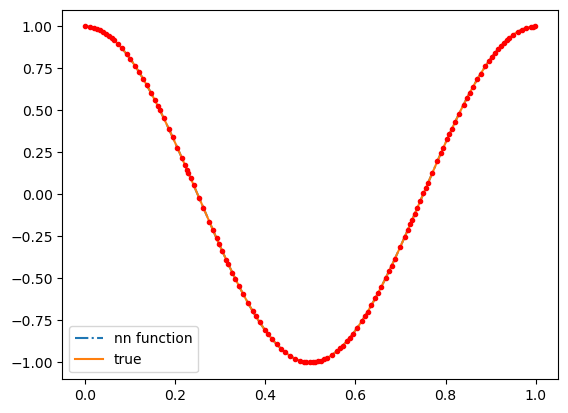

time taken:  5.897693634033203
neuron num 		 error 		 order
4 		 0.101483 		 * 		 0.869405 		 * 

8 		 0.002867 		 5.145680 		 0.076034 		 3.515315 

16 		 0.000082 		 5.130964 		 0.005190 		 3.872888 

32 		 0.000005 		 4.127836 		 0.000583 		 3.153698 

64 		 0.000000 		 4.266954 		 0.000063 		 3.210782 

128 		 0.000000 		 3.924804 		 0.000008 		 2.935510 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-2.00})$  & 	 $ | u -u_n |_{H^1}$ & 	 order $O(n^{-1.00})$  \\ \hline \hline 
4 		 & 0.101483 &		 * & 		 0.869405 & 		 *  \\ \hline  

8 		 &  2.867e-03 &  		 5.15 &  		 7.603e-02 &  		 3.52 \\ \hline  

16 		 &  8.181e-05 &  		 5.13 &  		 5.190e-03 &  		 3.87 \\ \hline  

32 		 &  4.680e-06 &  		 4.13 &  		 5.832e-04 &  		 3.15 \\ \hline  

64 		 &  2.431e-07 &  		 4.27 &  		 6.299e-05 &  		 3.21 \\ \hline  

128 		 &  1.600e-08 &  		 3.92 &  		 8.233e-06 &  		 2.94 \\ \hline  



In [26]:
def u_exact(x):
    return torch.cos(2*pi*x)

def du_exact(x):
    return -2 *pi*torch.sin(2*pi*x)

def rhs(x):
    return  (2*pi)**2 * torch.cos(2*pi*x) + nonlinear(torch.cos(2*pi*x))

def g_N(x):
    return du_exact(x) 
dim = 1 
function_name = "sine1d" 
filename_write = "data/1DRandCGA-PBE-{}-order.txt".format(function_name)
Nx = 2**13
order = 3   
f_write = open(filename_write, "a")
f_write.write("Numerical integration Nx: {}, order: {} \n".format(Nx, order))
f_write.close() 
save = True 
write2file = True 
memory = 2**29 
for N in [2**10]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 7
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    relu_k = 3  
    err_QMC2, err_h10, my_model = CGARandPBEReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =relu_k , solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order2(err_QMC2,err_h10,exponent,N,filename_write,write2file)
    show_convergence_order_latex2(err_QMC2,err_h10,exponent, k = relu_k, d = dim )

    

## Gabor function test 

The function is given by 
\begin{equation}
    \label{eq:gabor}
    u(x)  = \exp(-\frac{\sum_{i = 1}^d (x_i - 0.5)^2}{2 \sigma^2}) \cos(2\pi m x_1 ),  
\end{equation}
where $\sigma = 0.15$ and $ m = 4$, 


using linear solver:  direct
epoch:  1
torch.Size([2, 256])
one output
argmax time:  0.007358074188232422
selected neuron index:  tensor(58, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.4972158, device='cuda:0')
newton iteration:  1
torch.Size([1, 1])
sol_update_l2_norm:0.2738534405772793 	 residual l2 norm: 0.016155694307616927 
newton iteration:  2
torch.Size([1, 1])
sol_update_l2_norm:5.862786389691288e-07 	 residual l2 norm: 3.4587110765704754e-08 
newton iteration:  3
torch.Size([1, 1])
sol_update_l2_norm:5.880984540170831e-17 	 residual l2 norm: 3.469446951953614e-18 
converged at iteration:  3
sol_update_l2_norm:5.880984540170831e-17 	 residual l2 norm: 3.469446951953614e-18 
epoch:  2
torch.Size([2, 256])
two outputs
argmax time:  0.007534980773925781
selected neuron index:  tensor(121, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.0038128, device='cuda:0')
newton iteration:  1
torch.Size([1, 2])
sol_update_l2_norm:1.4017519971034735 	 residual l2 norm: 0.019

two outputs
argmax time:  0.007357358932495117
selected neuron index:  tensor(243, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.2657883, device='cuda:0')
newton iteration:  1
torch.Size([1, 21])
sol_update_l2_norm:813.0123676100033 	 residual l2 norm: 1.7472742591703466e-05 
newton iteration:  2
torch.Size([1, 21])
sol_update_l2_norm:2.996337799450776e-05 	 residual l2 norm: 3.491273055292367e-08 
newton iteration:  3
torch.Size([1, 21])
sol_update_l2_norm:3.410326986619424e-08 	 residual l2 norm: 1.5816188116697486e-13 
converged at iteration:  3
sol_update_l2_norm:3.410326986619424e-08 	 residual l2 norm: 1.5816188116697486e-13 
epoch:  22
torch.Size([2, 256])
two outputs
argmax time:  0.00817108154296875
selected neuron index:  tensor(10, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.6630428, device='cuda:0')
newton iteration:  1
torch.Size([1, 22])
sol_update_l2_norm:569.9791062825476 	 residual l2 norm: 2.122240561439389e-05 
newton iteration:  2
torch.Size([1, 

torch.Size([1, 35])
sol_update_l2_norm:4.261642365894146e-07 	 residual l2 norm: 1.925209419367663e-13 
converged at iteration:  3
sol_update_l2_norm:4.261642365894146e-07 	 residual l2 norm: 1.925209419367663e-13 
epoch:  36
torch.Size([2, 256])
two outputs
argmax time:  0.007409811019897461
selected neuron index:  tensor(228, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9455224, device='cuda:0')
newton iteration:  1
torch.Size([1, 36])
sol_update_l2_norm:75.71297381027173 	 residual l2 norm: 8.573924858459713e-07 
newton iteration:  2
torch.Size([1, 36])
sol_update_l2_norm:1.0417317990211859e-05 	 residual l2 norm: 8.7135292588305e-12 
newton iteration:  3
torch.Size([1, 36])
sol_update_l2_norm:8.560657409858899e-07 	 residual l2 norm: 9.130160772678337e-14 
converged at iteration:  3
sol_update_l2_norm:8.560657409858899e-07 	 residual l2 norm: 9.130160772678337e-14 
epoch:  37
torch.Size([2, 256])
two outputs
argmax time:  0.0074863433837890625
selected neuron index:  tens

torch.Size([2, 256])
two outputs
argmax time:  0.007457733154296875
selected neuron index:  tensor(59, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.2213952, device='cuda:0')
newton iteration:  1
torch.Size([1, 49])
sol_update_l2_norm:294.7755102981558 	 residual l2 norm: 6.2692361773275115e-06 
newton iteration:  2
torch.Size([1, 49])
sol_update_l2_norm:0.00035897958458332006 	 residual l2 norm: 1.5621009606622926e-11 
newton iteration:  3
torch.Size([1, 49])
sol_update_l2_norm:6.031795763695943e-06 	 residual l2 norm: 1.2712660295830858e-13 
newton iteration:  4
torch.Size([1, 49])
sol_update_l2_norm:5.573720378052613e-06 	 residual l2 norm: 7.45820246353881e-14 
converged at iteration:  4
sol_update_l2_norm:5.573720378052613e-06 	 residual l2 norm: 7.45820246353881e-14 
epoch:  50
torch.Size([2, 256])
two outputs
argmax time:  0.0074901580810546875
selected neuron index:  tensor(4, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.9636086, device='cuda:0')
newton itera

torch.Size([1, 57])
sol_update_l2_norm:1.8013464823263042e-05 	 residual l2 norm: 1.6514943108810444e-13 
newton iteration:  5
torch.Size([1, 57])
sol_update_l2_norm:7.606309421056678e-06 	 residual l2 norm: 1.697765840826406e-13 
newton iteration:  6
torch.Size([1, 57])
sol_update_l2_norm:1.4214841530940625e-05 	 residual l2 norm: 2.2146961331354997e-13 
newton iteration:  7
torch.Size([1, 57])
sol_update_l2_norm:9.884949458495866e-06 	 residual l2 norm: 9.468259369938031e-14 
converged at iteration:  7
sol_update_l2_norm:9.884949458495866e-06 	 residual l2 norm: 9.468259369938031e-14 
epoch:  58
torch.Size([2, 256])
two outputs
argmax time:  0.007559061050415039
selected neuron index:  tensor(160, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4885474, device='cuda:0')
newton iteration:  1
torch.Size([1, 58])
sol_update_l2_norm:925.3562596333727 	 residual l2 norm: 6.298797265638179e-05 
newton iteration:  2
torch.Size([1, 58])
sol_update_l2_norm:0.001586327915918693 	 residu

torch.Size([1, 67])
sol_update_l2_norm:0.0010353927501069035 	 residual l2 norm: 4.81573337831459e-13 
newton iteration:  3
torch.Size([1, 67])
sol_update_l2_norm:1.7846724972858088e-05 	 residual l2 norm: 1.4922943711024992e-14 
converged at iteration:  3
sol_update_l2_norm:1.7846724972858088e-05 	 residual l2 norm: 1.4922943711024992e-14 
epoch:  68
torch.Size([2, 256])
two outputs
argmax time:  0.008451223373413086
selected neuron index:  tensor(230, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.2733939, device='cuda:0')
newton iteration:  1
torch.Size([1, 68])
sol_update_l2_norm:133.37629270804646 	 residual l2 norm: 1.3246640176487938e-05 
newton iteration:  2
torch.Size([1, 68])
sol_update_l2_norm:0.0002331220904316855 	 residual l2 norm: 1.762367947668199e-12 
newton iteration:  3
torch.Size([1, 68])
sol_update_l2_norm:1.2577033126702214e-05 	 residual l2 norm: 1.2031376657802755e-13 
newton iteration:  4
torch.Size([1, 68])
sol_update_l2_norm:2.222325775142583e-05 	 re

torch.Size([1, 75])
sol_update_l2_norm:3.868122360818107e-05 	 residual l2 norm: 1.4659308795949403e-13 
newton iteration:  4
torch.Size([1, 75])
sol_update_l2_norm:3.4262202700751954e-05 	 residual l2 norm: 1.2096031538142255e-13 
newton iteration:  5
torch.Size([1, 75])
sol_update_l2_norm:3.655459195769191e-05 	 residual l2 norm: 3.236479539288547e-14 
converged at iteration:  5
sol_update_l2_norm:3.655459195769191e-05 	 residual l2 norm: 3.236479539288547e-14 
epoch:  76
torch.Size([2, 256])
two outputs
argmax time:  0.007695913314819336
selected neuron index:  tensor(254, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3792252, device='cuda:0')
newton iteration:  1
torch.Size([1, 76])
sol_update_l2_norm:353.3985713064613 	 residual l2 norm: 0.00012933341629386614 
newton iteration:  2
torch.Size([1, 76])
sol_update_l2_norm:0.0019842860435121965 	 residual l2 norm: 1.2566773704328739e-12 
newton iteration:  3
torch.Size([1, 76])
sol_update_l2_norm:5.6768606521306536e-05 	 res

torch.Size([1, 83])
sol_update_l2_norm:7.864923927030971e-05 	 residual l2 norm: 9.422181750723232e-14 
converged at iteration:  8
sol_update_l2_norm:7.864923927030971e-05 	 residual l2 norm: 9.422181750723232e-14 
epoch:  84
torch.Size([2, 256])
two outputs
argmax time:  0.0077533721923828125
selected neuron index:  tensor(220, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5940486, device='cuda:0')
newton iteration:  1
torch.Size([1, 84])
sol_update_l2_norm:512.4335435161989 	 residual l2 norm: 4.5965955680671275e-05 
newton iteration:  2
torch.Size([1, 84])
sol_update_l2_norm:0.004100064435220425 	 residual l2 norm: 8.582949476191265e-13 
newton iteration:  3
torch.Size([1, 84])
sol_update_l2_norm:5.332010597776391e-05 	 residual l2 norm: 1.468788160613772e-13 
newton iteration:  4
torch.Size([1, 84])
sol_update_l2_norm:7.77690053732243e-05 	 residual l2 norm: 1.178988191706323e-13 
newton iteration:  5
torch.Size([1, 84])
sol_update_l2_norm:8.89554515549727e-05 	 residual l

torch.Size([1, 93])
sol_update_l2_norm:0.00011286046059063478 	 residual l2 norm: 1.4255365423501817e-13 
newton iteration:  5
torch.Size([1, 93])
sol_update_l2_norm:0.00020449102903582247 	 residual l2 norm: 2.1109256377216756e-13 
newton iteration:  6
torch.Size([1, 93])
sol_update_l2_norm:0.00013529381206763762 	 residual l2 norm: 6.981416778121919e-14 
converged at iteration:  6
sol_update_l2_norm:0.00013529381206763762 	 residual l2 norm: 6.981416778121919e-14 
epoch:  94
torch.Size([2, 256])
two outputs
argmax time:  0.007822513580322266
selected neuron index:  tensor(162, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1815755, device='cuda:0')
newton iteration:  1
torch.Size([1, 94])
sol_update_l2_norm:68.61376006060118 	 residual l2 norm: 4.403388406226109e-06 
newton iteration:  2
torch.Size([1, 94])
sol_update_l2_norm:0.0038114905791025748 	 residual l2 norm: 3.2423658138757066e-13 
newton iteration:  3
torch.Size([1, 94])
sol_update_l2_norm:0.0001450595716745777 	 re

torch.Size([2, 256])
two outputs
argmax time:  0.008342266082763672
selected neuron index:  tensor(138, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7978161, device='cuda:0')
newton iteration:  1
torch.Size([1, 105])
sol_update_l2_norm:175.67063432667317 	 residual l2 norm: 0.00028827563711700634 
newton iteration:  2
torch.Size([1, 105])
sol_update_l2_norm:0.022376125333104124 	 residual l2 norm: 3.077994273033882e-13 
newton iteration:  3
torch.Size([1, 105])
sol_update_l2_norm:0.00032163154557114063 	 residual l2 norm: 2.2503724955683866e-13 
newton iteration:  4
torch.Size([1, 105])
sol_update_l2_norm:0.00032306525736204323 	 residual l2 norm: 4.03939176835374e-14 
converged at iteration:  4
sol_update_l2_norm:0.00032306525736204323 	 residual l2 norm: 4.03939176835374e-14 
epoch:  106
torch.Size([2, 256])
two outputs
argmax time:  0.009613513946533203
selected neuron index:  tensor(218, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7670694, device='cuda:0')
newt

torch.Size([1, 116])
sol_update_l2_norm:646.0490639447632 	 residual l2 norm: 4.943732268870225e-05 
newton iteration:  2
torch.Size([1, 116])
sol_update_l2_norm:0.04512004601769615 	 residual l2 norm: 1.8059514019715618e-13 
newton iteration:  3
torch.Size([1, 116])
sol_update_l2_norm:0.0004598124637632546 	 residual l2 norm: 1.8047187245364935e-13 
newton iteration:  4
torch.Size([1, 116])
sol_update_l2_norm:0.0005645256924974749 	 residual l2 norm: 2.251558883943619e-13 
newton iteration:  5
torch.Size([1, 116])
sol_update_l2_norm:0.0004043256231765475 	 residual l2 norm: 1.6846073159678264e-13 
newton iteration:  6
torch.Size([1, 116])
sol_update_l2_norm:0.0004717241504110155 	 residual l2 norm: 2.921027201484221e-13 
newton iteration:  7
torch.Size([1, 116])
sol_update_l2_norm:0.0005001173230221996 	 residual l2 norm: 1.7004024370749228e-13 
newton iteration:  8
torch.Size([1, 116])
sol_update_l2_norm:0.0006372869583983795 	 residual l2 norm: 8.20454539056083e-14 
converged at ite

torch.Size([1, 127])
sol_update_l2_norm:0.0008641692789755737 	 residual l2 norm: 1.755355146819221e-13 
newton iteration:  5
torch.Size([1, 127])
sol_update_l2_norm:0.001336707778360635 	 residual l2 norm: 1.1635313226848006e-13 
newton iteration:  6
torch.Size([1, 127])
sol_update_l2_norm:0.0008843249370594677 	 residual l2 norm: 9.316111155695076e-14 
converged at iteration:  6
sol_update_l2_norm:0.0008843249370594677 	 residual l2 norm: 9.316111155695076e-14 
epoch:  128
torch.Size([2, 256])
two outputs
argmax time:  0.008073568344116211
selected neuron index:  tensor(149, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.1063190, device='cuda:0')
newton iteration:  1
torch.Size([1, 128])
sol_update_l2_norm:32.3335977379709 	 residual l2 norm: 1.1427141989557949e-06 
newton iteration:  2
torch.Size([1, 128])
sol_update_l2_norm:0.00283770385337762 	 residual l2 norm: 1.588974496410416e-13 
newton iteration:  3
torch.Size([1, 128])
sol_update_l2_norm:0.0006757310682832507 	 resi

torch.Size([1, 137])
sol_update_l2_norm:136.49097029110987 	 residual l2 norm: 3.245121366335971e-05 
newton iteration:  2
torch.Size([1, 137])
sol_update_l2_norm:0.04646179813326254 	 residual l2 norm: 9.539795463220467e-14 
converged at iteration:  2
sol_update_l2_norm:0.04646179813326254 	 residual l2 norm: 9.539795463220467e-14 
epoch:  138
torch.Size([2, 256])
two outputs
argmax time:  0.008254766464233398
selected neuron index:  tensor(48, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.8893460, device='cuda:0')
newton iteration:  1
torch.Size([1, 138])
sol_update_l2_norm:46.2024520109529 	 residual l2 norm: 1.235027719242292e-06 
newton iteration:  2
torch.Size([1, 138])
sol_update_l2_norm:0.023857409481136908 	 residual l2 norm: 1.8783138610189968e-13 
newton iteration:  3
torch.Size([1, 138])
sol_update_l2_norm:0.0010569621824239224 	 residual l2 norm: 1.9958391189311825e-13 
newton iteration:  4
torch.Size([1, 138])
sol_update_l2_norm:0.0010959771974482307 	 residual l

torch.Size([1, 145])
sol_update_l2_norm:0.0016467346728526275 	 residual l2 norm: 9.534776208387749e-14 
converged at iteration:  8
sol_update_l2_norm:0.0016467346728526275 	 residual l2 norm: 9.534776208387749e-14 
epoch:  146
torch.Size([2, 256])
two outputs
argmax time:  0.009270668029785156
selected neuron index:  tensor(39, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.5975616, device='cuda:0')
newton iteration:  1
torch.Size([1, 146])
sol_update_l2_norm:344.162465241045 	 residual l2 norm: 0.00015505944598519754 
newton iteration:  2
torch.Size([1, 146])
sol_update_l2_norm:0.14011922467914803 	 residual l2 norm: 2.2329276692306947e-13 
newton iteration:  3
torch.Size([1, 146])
sol_update_l2_norm:0.0013754190607804524 	 residual l2 norm: 4.034871333605129e-14 
converged at iteration:  3
sol_update_l2_norm:0.0013754190607804524 	 residual l2 norm: 4.034871333605129e-14 
epoch:  147
torch.Size([2, 256])
two outputs
argmax time:  0.00844573974609375
selected neuron index:  t

torch.Size([1, 155])
sol_update_l2_norm:0.0028739230955776122 	 residual l2 norm: 3.032043308170189e-13 
newton iteration:  7
torch.Size([1, 155])
sol_update_l2_norm:0.0026026909905211486 	 residual l2 norm: 9.918046918245714e-14 
converged at iteration:  7
sol_update_l2_norm:0.0026026909905211486 	 residual l2 norm: 9.918046918245714e-14 
epoch:  156
torch.Size([2, 256])
two outputs
argmax time:  0.008503437042236328
selected neuron index:  tensor(7, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.7872606, device='cuda:0')
newton iteration:  1
torch.Size([1, 156])
sol_update_l2_norm:76.85666040588117 	 residual l2 norm: 8.647774544017432e-06 
newton iteration:  2
torch.Size([1, 156])
sol_update_l2_norm:0.0654995420175176 	 residual l2 norm: 1.2982823466166905e-13 
newton iteration:  3
torch.Size([1, 156])
sol_update_l2_norm:0.00311268216548941 	 residual l2 norm: 1.7514419278603211e-13 
newton iteration:  4
torch.Size([1, 156])
sol_update_l2_norm:0.0022903014343032303 	 residua

torch.Size([1, 167])
sol_update_l2_norm:134.11666962838405 	 residual l2 norm: 4.487193045769749e-05 
newton iteration:  2
torch.Size([1, 167])
sol_update_l2_norm:0.08892361555558805 	 residual l2 norm: 2.2281742984482258e-13 
newton iteration:  3
torch.Size([1, 167])
sol_update_l2_norm:0.0039324630798689775 	 residual l2 norm: 8.971848303837972e-14 
converged at iteration:  3
sol_update_l2_norm:0.0039324630798689775 	 residual l2 norm: 8.971848303837972e-14 
epoch:  168
torch.Size([2, 256])
two outputs
argmax time:  0.008587360382080078
selected neuron index:  tensor(183, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.9394905, device='cuda:0')
newton iteration:  1
torch.Size([1, 168])
sol_update_l2_norm:13.756845765313544 	 residual l2 norm: 0.0005268368524293159 
newton iteration:  2
torch.Size([1, 168])
sol_update_l2_norm:0.02138072210444687 	 residual l2 norm: 6.065535757908065e-13 
newton iteration:  3
torch.Size([1, 168])
sol_update_l2_norm:0.003416989422825379 	 residual

torch.Size([1, 177])
sol_update_l2_norm:0.005621997833986739 	 residual l2 norm: 1.24614322789598e-13 
newton iteration:  4
torch.Size([1, 177])
sol_update_l2_norm:0.0037328665451520603 	 residual l2 norm: 1.7930396857296043e-13 
newton iteration:  5
torch.Size([1, 177])
sol_update_l2_norm:0.003867118104527692 	 residual l2 norm: 1.3447413192817733e-13 
newton iteration:  6
torch.Size([1, 177])
sol_update_l2_norm:0.0037384376954770044 	 residual l2 norm: 1.8337781668901435e-13 
newton iteration:  7
torch.Size([1, 177])
sol_update_l2_norm:0.003050531997334534 	 residual l2 norm: 1.8960356218737779e-13 
newton iteration:  8
torch.Size([1, 177])
sol_update_l2_norm:0.0025493374843029793 	 residual l2 norm: 5.662813369040157e-15 
converged at iteration:  8
sol_update_l2_norm:0.0025493374843029793 	 residual l2 norm: 5.662813369040157e-15 
epoch:  178
torch.Size([2, 256])
two outputs
argmax time:  0.008769989013671875
selected neuron index:  tensor(224, device='cuda:0') tensor(1., device='cu

torch.Size([1, 185])
sol_update_l2_norm:0.007455480683569936 	 residual l2 norm: 9.38867684731645e-14 
converged at iteration:  8
sol_update_l2_norm:0.007455480683569936 	 residual l2 norm: 9.38867684731645e-14 
epoch:  186
torch.Size([2, 256])
two outputs
argmax time:  0.008759260177612305
selected neuron index:  tensor(49, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3899768, device='cuda:0')
newton iteration:  1
torch.Size([1, 186])
sol_update_l2_norm:281.5790512794948 	 residual l2 norm: 0.00016846761060476862 
newton iteration:  2
torch.Size([1, 186])
sol_update_l2_norm:0.4270692390169494 	 residual l2 norm: 1.6420159491729286e-13 
newton iteration:  3
torch.Size([1, 186])
sol_update_l2_norm:0.0066792147563205185 	 residual l2 norm: 2.259549747804544e-13 
newton iteration:  4
torch.Size([1, 186])
sol_update_l2_norm:0.004770549510933113 	 residual l2 norm: 8.349721150185162e-14 
converged at iteration:  4
sol_update_l2_norm:0.004770549510933113 	 residual l2 norm: 8.34972

torch.Size([1, 195])
sol_update_l2_norm:0.006727057351634697 	 residual l2 norm: 2.1824296123147762e-13 
newton iteration:  4
torch.Size([1, 195])
sol_update_l2_norm:0.007881327997943761 	 residual l2 norm: 1.9302766724633254e-13 
newton iteration:  5
torch.Size([1, 195])
sol_update_l2_norm:0.009747045119217576 	 residual l2 norm: 1.5135942380228556e-13 
newton iteration:  6
torch.Size([1, 195])
sol_update_l2_norm:0.007782867364267454 	 residual l2 norm: 6.639282898304024e-14 
converged at iteration:  6
sol_update_l2_norm:0.007782867364267454 	 residual l2 norm: 6.639282898304024e-14 
epoch:  196
torch.Size([2, 256])
two outputs
argmax time:  0.010531187057495117
selected neuron index:  tensor(63, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.4994288, device='cuda:0')
newton iteration:  1
torch.Size([1, 196])
sol_update_l2_norm:242.0793871558504 	 residual l2 norm: 0.00010587343165223663 
newton iteration:  2
torch.Size([1, 196])
sol_update_l2_norm:0.2617803506029882 	 residua

torch.Size([1, 205])
sol_update_l2_norm:72.0998417032065 	 residual l2 norm: 6.2858275461057e-06 
newton iteration:  2
torch.Size([1, 205])
sol_update_l2_norm:0.42587857802489804 	 residual l2 norm: 1.6678616181508188e-13 
newton iteration:  3
torch.Size([1, 205])
sol_update_l2_norm:0.010316550783459917 	 residual l2 norm: 7.288124954507944e-14 
converged at iteration:  3
sol_update_l2_norm:0.010316550783459917 	 residual l2 norm: 7.288124954507944e-14 
epoch:  206
torch.Size([2, 256])
two outputs
argmax time:  0.00887298583984375
selected neuron index:  tensor(224, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.3232412, device='cuda:0')
newton iteration:  1
torch.Size([1, 206])
sol_update_l2_norm:131.03538442757565 	 residual l2 norm: 0.00023832863195565564 
newton iteration:  2
torch.Size([1, 206])
sol_update_l2_norm:0.3207770517405691 	 residual l2 norm: 1.479791601432498e-13 
newton iteration:  3
torch.Size([1, 206])
sol_update_l2_norm:0.009870376301870062 	 residual l2 nor

torch.Size([1, 212])
sol_update_l2_norm:0.010774979282225145 	 residual l2 norm: 1.2429023797184162e-13 
newton iteration:  8
torch.Size([1, 212])
sol_update_l2_norm:0.009262304586054117 	 residual l2 norm: 1.9806743437137206e-13 
newton iteration:  9
torch.Size([1, 212])
sol_update_l2_norm:0.010070827678746149 	 residual l2 norm: 1.185604873069766e-13 
newton iteration:  10
torch.Size([1, 212])
sol_update_l2_norm:0.014782287104703001 	 residual l2 norm: 3.376958247693598e-14 
converged at iteration:  10
sol_update_l2_norm:0.014782287104703001 	 residual l2 norm: 3.376958247693598e-14 
epoch:  213
torch.Size([2, 256])
two outputs
argmax time:  0.008957386016845703
selected neuron index:  tensor(174, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5675731, device='cuda:0')
newton iteration:  1
torch.Size([1, 213])
sol_update_l2_norm:202.13566104045282 	 residual l2 norm: 7.182703931151214e-05 
newton iteration:  2
torch.Size([1, 213])
sol_update_l2_norm:0.307958960353924 	 residu

torch.Size([1, 221])
sol_update_l2_norm:0.013307288707193278 	 residual l2 norm: 1.4050391951728746e-13 
newton iteration:  5
torch.Size([1, 221])
sol_update_l2_norm:0.017938231787209033 	 residual l2 norm: 3.0462162441315554e-13 
newton iteration:  6
torch.Size([1, 221])
sol_update_l2_norm:0.01537999601492864 	 residual l2 norm: 1.1560065635101308e-13 
newton iteration:  7
torch.Size([1, 221])
sol_update_l2_norm:0.018443217137271997 	 residual l2 norm: 2.4581597318234493e-13 
newton iteration:  8
torch.Size([1, 221])
sol_update_l2_norm:0.02297704443597197 	 residual l2 norm: 9.199749130740496e-14 
converged at iteration:  8
sol_update_l2_norm:0.02297704443597197 	 residual l2 norm: 9.199749130740496e-14 
epoch:  222
torch.Size([2, 256])
two outputs
argmax time:  0.010868072509765625
selected neuron index:  tensor(13, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.5449704, device='cuda:0')
newton iteration:  1
torch.Size([1, 222])
sol_update_l2_norm:94.78712452737031 	 residual

torch.Size([1, 232])
sol_update_l2_norm:0.023946355252141307 	 residual l2 norm: 1.278726246415012e-13 
newton iteration:  4
torch.Size([1, 232])
sol_update_l2_norm:0.018495217782302054 	 residual l2 norm: 1.1226718031042644e-13 
newton iteration:  5
torch.Size([1, 232])
sol_update_l2_norm:0.02177596710988161 	 residual l2 norm: 2.6327271835013237e-14 
converged at iteration:  5
sol_update_l2_norm:0.02177596710988161 	 residual l2 norm: 2.6327271835013237e-14 
epoch:  233
torch.Size([2, 256])
two outputs
argmax time:  0.009019851684570312
selected neuron index:  tensor(54, device='cuda:0') tensor(-1., device='cuda:0') tensor(0.7442912, device='cuda:0')
newton iteration:  1
torch.Size([1, 233])
sol_update_l2_norm:35.26730625052539 	 residual l2 norm: 0.00032333587243743713 
newton iteration:  2
torch.Size([1, 233])
sol_update_l2_norm:0.2821491987826754 	 residual l2 norm: 1.277117176115831e-13 
newton iteration:  3
torch.Size([1, 233])
sol_update_l2_norm:0.030900867661812922 	 residual 

newton iteration:  1
torch.Size([1, 244])
sol_update_l2_norm:87.37307409759205 	 residual l2 norm: 1.0219041412665303e-05 
newton iteration:  2
torch.Size([1, 244])
sol_update_l2_norm:0.45616359688874475 	 residual l2 norm: 2.714668373761596e-13 
newton iteration:  3
torch.Size([1, 244])
sol_update_l2_norm:0.03082219917331707 	 residual l2 norm: 3.0311364561054174e-13 
newton iteration:  4
torch.Size([1, 244])
sol_update_l2_norm:0.025324291324149966 	 residual l2 norm: 5.887258315553694e-14 
converged at iteration:  4
sol_update_l2_norm:0.025324291324149966 	 residual l2 norm: 5.887258315553694e-14 
epoch:  245
torch.Size([2, 256])
two outputs
argmax time:  0.011041641235351562
selected neuron index:  tensor(71, device='cuda:0') tensor(1., device='cuda:0') tensor(-0.2832180, device='cuda:0')
newton iteration:  1
torch.Size([1, 245])
sol_update_l2_norm:108.99417918771461 	 residual l2 norm: 0.0003143198444022369 
newton iteration:  2
torch.Size([1, 245])
sol_update_l2_norm:0.65182035167

newton iteration:  1
torch.Size([1, 255])
sol_update_l2_norm:112.43298468539936 	 residual l2 norm: 0.00028392602845183897 
newton iteration:  2
torch.Size([1, 255])
sol_update_l2_norm:1.6150649824066177 	 residual l2 norm: 3.916577611188675e-13 
newton iteration:  3
torch.Size([1, 255])
sol_update_l2_norm:0.07106588407764358 	 residual l2 norm: 1.146733470994025e-13 
newton iteration:  4
torch.Size([1, 255])
sol_update_l2_norm:0.032828703360450254 	 residual l2 norm: 1.2745481081415088e-13 
newton iteration:  5
torch.Size([1, 255])
sol_update_l2_norm:0.040435266440834935 	 residual l2 norm: 1.499311815697776e-13 
newton iteration:  6
torch.Size([1, 255])
sol_update_l2_norm:0.031074778276633325 	 residual l2 norm: 2.6709215346513195e-14 
converged at iteration:  6
sol_update_l2_norm:0.031074778276633325 	 residual l2 norm: 2.6709215346513195e-14 
epoch:  256
torch.Size([2, 256])
two outputs
argmax time:  0.01097249984741211
selected neuron index:  tensor(214, device='cuda:0') tensor(-1

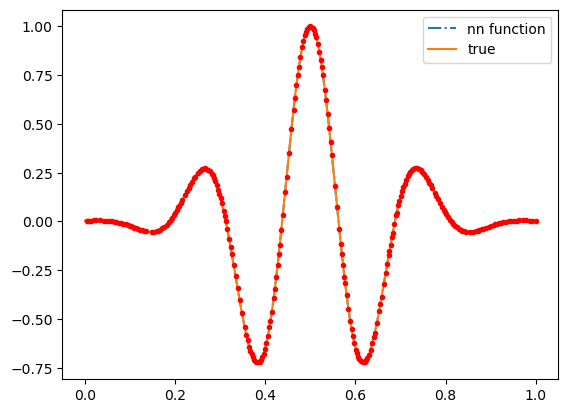

time taken:  35.160629749298096
neuron num 		 error 		 order
4 		 0.465563 		 * 		 9.267124 		 * 

8 		 0.334537 		 0.476812 		 7.333219 		 0.337675 

16 		 0.006250 		 5.742203 		 0.355001 		 4.368552 

32 		 0.000591 		 3.403444 		 0.075325 		 2.236631 

64 		 0.000014 		 5.380225 		 0.004240 		 4.150973 

128 		 0.000001 		 3.765823 		 0.000609 		 2.800555 

256 		 0.000000 		 3.992716 		 0.000077 		 2.987220 

neuron num  & 	 $\|u-u_n \|_{L^2}$ & 	 order $O(n^{-4.00})$  & 	 $ | u -u_n |_{H^1}$ & 	 order $O(n^{-3.00})$  \\ \hline \hline 
4 		 & 0.465563 &		 * & 		 9.267124 & 		 *  \\ \hline  

8 		 &  3.345e-01 &  		 0.48 &  		 7.333e+00 &  		 0.34 \\ \hline  

16 		 &  6.250e-03 &  		 5.74 &  		 3.550e-01 &  		 4.37 \\ \hline  

32 		 &  5.906e-04 &  		 3.40 &  		 7.532e-02 &  		 2.24 \\ \hline  

64 		 &  1.418e-05 &  		 5.38 &  		 4.240e-03 &  		 4.15 \\ \hline  

128 		 &  1.043e-06 &  		 3.77 &  		 6.086e-04 &  		 2.80 \\ \hline  

256 		 &  6.549e-08 &  		 3.99 &  		 7.675e-05

In [33]:
# sigma = 0.15
# m = 4 
import torch


# Parameters for the Gabor function
sigma = 0.15
m = 4 


def u_exact(x):
    """Gabor function applied to a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])  # x[:, 0:1] keeps the dimension
    return exp_term * cos_term

def du_exact(x):
    """First derivative of the Gabor function with respect to each component for a batch of points."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    # Derivative with respect to x_1
    du_dx1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term - (2 * math.pi * m * exp_term * sin_term)

    # Derivative with respect to other dimensions
    du_dx_other = exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2)) * cos_term

    # Concatenate all the derivatives to keep dimension
    du_dx = torch.cat([du_dx1, du_dx_other], dim=1)

    return du_dx

def laplace_u_exact(x):
    """Laplacian of the Gabor function for a batch of points, summed over all dimensions."""
    exp_term = torch.exp(-torch.sum((x - 0.5) ** 2, dim=1, keepdim=True) / (2 * sigma ** 2))
    cos_term = torch.cos(2 * math.pi * m * x[:, 0:1])
    sin_term = torch.sin(2 * math.pi * m * x[:, 0:1])

    exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * cos_term 
    - (2 * math.pi * m * exp_term * sin_term) 
    # Laplacian in x_1: Apply the product rule twice
    laplace_x1_part_1 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2))**2 * cos_term
    laplace_x1_part_2 = exp_term * ( - 1 / sigma ** 2) * cos_term
    laplace_x1_part_3 = exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * (-2*m*math.pi)*sin_term
    laplace_x1_part_4 = - (2 * math.pi * m * exp_term * (-2 * (x[:, 0:1] - 0.5) / (2 * sigma ** 2)) * sin_term) 
    laplace_x1_part_5 = - ( (2 * math.pi * m)**2 * exp_term * cos_term)

    laplace_x1 = laplace_x1_part_1 + laplace_x1_part_2 + laplace_x1_part_3 \
                + laplace_x1_part_4 + laplace_x1_part_5

    # Laplacian in other dimensions (x_i, i > 1): Only the exponential term matters here
    laplace_other = (-1 / sigma ** 2) * exp_term * (((x[:, 1:] - 0.5) ** 2 / sigma ** 2) - 1) * cos_term \
                + exp_term * (-2 * (x[:, 1:] - 0.5) / (2 * sigma ** 2))**2 * cos_term 

    # Sum all Laplacians over each variable to get the total Laplacian
    laplace_sum = laplace_x1  + torch.sum(laplace_other, dim=1, keepdim=True)

    return laplace_sum 

def rhs(x):
    """Right-hand side of the equation using the Gabor function for a batch of points."""
    laplace_sum = laplace_u_exact(x)
    return -laplace_sum + nonlinear(u_exact(x))

def g_N(x):
    return du_exact(x) 

dim = 1
function_name = "gabor1d-m4" 
filename_write = "data/1DOGA-PBE-{}-order.txt".format(function_name)
Nx = 2**14
order = 3
f_write = open(filename_write, "a")
f_write.write("Numerical integration Nx: {}, order: {} \n".format(Nx, order))
f_write.close() 
save = True 
write2file = True 
memory = 2**29 

for N in [2**8]: # 2**12,2**14
    
    f_write = open(filename_write, "a")
    my_model = None 
    exponent = 8
    num_epochs = 2**exponent  
    plot_freq = num_epochs 
    relu_k = 3 
    err_QMC2, err_h10, my_model = CGARandPBEReLU1D(None,rhs,u_exact,du_exact,g_N, N,num_epochs,plot_freq, Nx, order, k =relu_k, solver = "direct")
    
    if save: 
        folder = 'data/'
        filename = folder + 'err_CGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(err_QMC2,filename) 
        folder = 'data/'
        filename = folder + 'model_CGA_1D_{}_neuron_{}_N_{}_randomized.pt'.format(function_name,num_epochs,N)
        torch.save(my_model,filename)
    
    show_convergence_order2(err_QMC2,err_h10,exponent,N,filename_write,write2file=write2file)
    show_convergence_order_latex2(err_QMC2,err_h10,exponent,k =relu_k, d = dim)



#### arctan example 